In [1]:
import detectron2

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# import some common libraries
import sys
import csv
import base64
import time
import os
import json
import numpy as np
import collections
import io
import cv2
import torch

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [2]:
csv.field_size_limit(sys.maxsize)
FIELDNAMES = ["img_id", "img_h", "img_w", "objects_id", "objects_conf",
              "attrs_id", "attrs_conf", "num_boxes", "boxes", "features"]

## Utils

In [3]:
# Show the image in ipynb
from IPython.display import clear_output, Image, display
import PIL.Image
def showarray(a, fmt='png'):
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

In [4]:
def load_obj_tsv(fname, ids, topk=None):
    """Load object features from tsv file.
    :param fname: The path to the tsv file.
    :param topk: Only load features for top K images (lines) in the tsv file.
        Will load all the features if topk is either -1 or None.
    :return: A list of image object features where each feature is a dict.
        See FIELDNAMES above for the keys in the feature dit.
    """
    data = []
    start_time = time.time()
    print("Start to load Faster-RCNN detected objects from %s" % fname)
    with open(fname) as f:
        reader = csv.DictReader(f, FIELDNAMES, delimiter="\t")
        boxes = 36 # args.num_features  # Same boxes for all

        for i, item in enumerate(reader):

            # Check if id in list of ids to save memory
            if int(item["img_id"]) not in ids:
                continue

            for key in ['img_h', 'img_w', 'num_boxes']:
                item[key] = int(item[key])

            boxes = item['num_boxes']
            decode_config = [
                ('objects_id', (boxes,), np.int64),
                ('objects_conf', (boxes,), np.float32),
                ('attrs_id', (boxes,), np.int64),
                ('attrs_conf', (boxes,), np.float32),
                ('boxes', (boxes, 4), np.float32),
                ('features', (boxes, -1), np.float32),
            ]
            for key, shape, dtype in decode_config:
                item[key] = np.frombuffer(base64.b64decode(item[key]), dtype=dtype)
                try:
                    item[key] = item[key].reshape(shape)
                except:
                    # In 1 out of 10K cases, the shape comes out wrong; We make necessary adjustments
                    shape = list(shape)
                    shape[0] += 1
                    shape = tuple(shape)
                    item[key] = item[key].reshape(shape)

                item[key].setflags(write=False)

            data.append(item)
            if topk is not None and len(data) == topk:
                break
    elapsed_time = time.time() - start_time
    print("Loaded %d images in file %s in %d seconds." % (len(data), fname, elapsed_time))
    return data

In [5]:
class DictWrapper(dict):
    def has(self, key):
        return key in self.keys()
    @property
    def pred_boxes(self):
        return self.get('pred_boxes')
    @property
    def scores(self):
        return self.get('scores')
    @property
    def pred_classes(self):
        return self.get('pred_classes')
    @property
    def attr_scores(self):
        return self.get('attr_scores')
    @property
    def attr_classes(self):
        return self.get('attr_classes')

## Config

In [6]:
# Load VG Classes
data_path = '/home/miproj/4thyr.oct2020/ojrb2/vilio/features/vilio/py-bottom-up-attention/demo/data/genome/1600-400-20/'

vg_classes = []
with open(os.path.join(data_path, 'objects_vocab.txt')) as f:
    for object in f.readlines():
        vg_classes.append(object.split(',')[0].lower().strip())
        
vg_attrs = []
with open(os.path.join(data_path, 'attributes_vocab.txt')) as f:
    for object in f.readlines():
        vg_attrs.append(object.split(',')[0].lower().strip())


MetadataCatalog.get("vg").thing_classes = vg_classes
MetadataCatalog.get("vg").attr_classes = vg_attrs

In [7]:
cfg = get_cfg()
cfg.merge_from_file("/home/miproj/4thyr.oct2020/ojrb2/vilio/features/vilio/py-bottom-up-attention/configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml") ##
cfg.MODEL.RPN.POST_NMS_TOPK_TEST = 300
cfg.MODEL.ROI_HEADS.NMS_THRESH_TEST = 0.6
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.2
cfg.INPUT.MIN_SIZE_TEST = 600
cfg.INPUT.MAX_SIZE_TEST = 1000
cfg.MODEL.RPN.NMS_THRESH = 0.7
# VG Weight
cfg.MODEL.WEIGHTS = "http://nlp.cs.unc.edu/models/faster_rcnn_from_caffe_attr.pkl"

Config '/home/miproj/4thyr.oct2020/ojrb2/vilio/features/vilio/py-bottom-up-attention/configs/VG-Detection/faster_rcnn_R_101_C4_attr_caffemaxpool.yaml' has no VERSION. Assuming it to be compatible with latest v2.


## Load Data

In [28]:
data_dir = '/home/miproj/4thyr.oct2020/ojrb2/vilio/data/'
feature_dir = os.path.join(data_dir, 'features')
anno_dir = os.path.join(feature_dir, 'annotations')
img_dir = os.path.join(data_dir, 'img')
features = os.path.join(feature_dir, 'tsv/20a.tsv')

In [29]:
# Loading detection features to img_data
ids = [int(file.split('.')[0]) for file in os.listdir(img_dir)]
img_data = load_obj_tsv(features, ids, topk=-1)

# Convert img list to dict
imgid2img = {}
for img_datum in img_data:
    # Adding int here to convert 0625 to 625
    imgid2img[img_datum['img_id']] = img_datum

Start to load Faster-RCNN detected objects from /home/miproj/4thyr.oct2020/ojrb2/vilio/data/features/tsv/20a.tsv
Loaded 12140 images in file /home/miproj/4thyr.oct2020/ojrb2/vilio/data/features/tsv/20a.tsv in 190 seconds.


In [26]:
img = '03942'

### Original

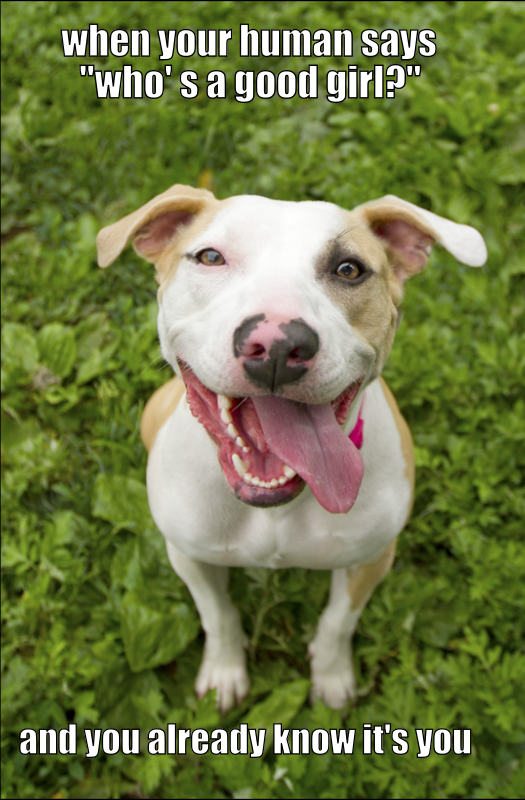

In [11]:
im = cv2.imread(os.path.join(img_dir, f'{img}.png'))
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
showarray(im_rgb)

### VG Attr 20

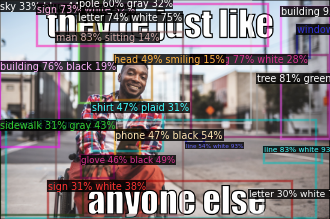

In [32]:
# Wrap data as appropriate
im_data = imgid2img[img]
pred = DictWrapper({"pred_boxes": im_data['boxes'], 
        "pred_classes": im_data['objects_id'], 
        "scores": im_data['objects_conf'], 
        "attr_classes": im_data['attrs_id'], 
        "attr_scores": im_data['attrs_conf'],
       })

# Show the boxes, labels, and features
im = cv2.imread(os.path.join(img_dir, f'{img}.png'))
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
v = Visualizer(im[:, :, :], MetadataCatalog.get("vg"), scale=0.6)
v = v.draw_instance_predictions(pred)
showarray(v.get_image()[:, :, ::-1])

### VG 10

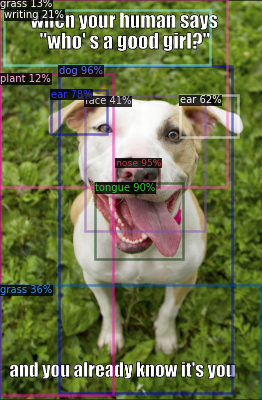

In [13]:
# Wrap data as appropriate
im_data = imgid2img[img]
pred = DictWrapper({"pred_boxes": im_data['boxes'], 
        "pred_classes": im_data['objects_id'], 
        "scores": im_data['objects_conf'], 
       })

# Show the boxes, labels, and features
im = cv2.imread(os.path.join(img_dir, f'{img}.png'))
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
v = Visualizer(im[:, :, :], MetadataCatalog.get("vg"), scale=0.5)
v = v.draw_instance_predictions(pred)
showarray(v.get_image()[:, :, ::-1])

### VG 20

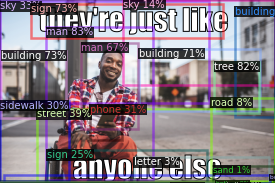

In [27]:
# Wrap data as appropriate
im_data = imgid2img[img]
pred = DictWrapper({"pred_boxes": im_data['boxes'], 
        "pred_classes": im_data['objects_id'], 
        "scores": im_data['objects_conf'], 
       })

# Show the boxes, labels, and features
im = cv2.imread(os.path.join(img_dir, f'{img}.png'))
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
v = Visualizer(im[:, :, :], MetadataCatalog.get("vg"), scale=0.5)
v = v.draw_instance_predictions(pred)
showarray(v.get_image()[:, :, ::-1])

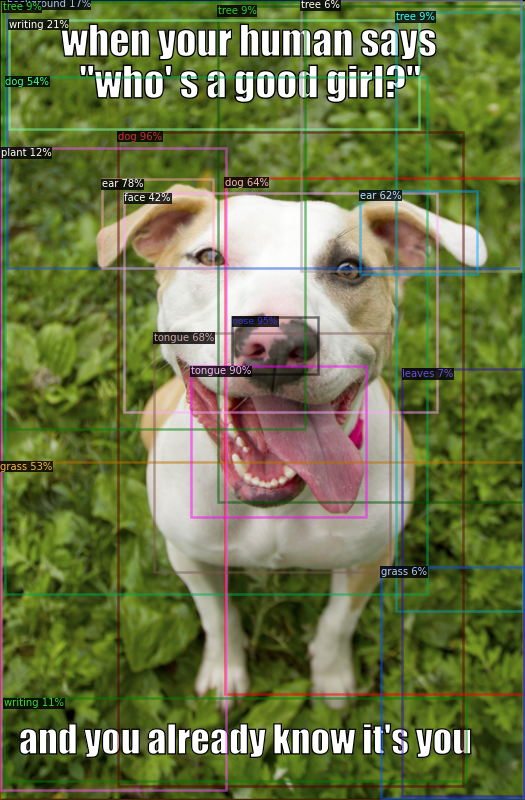

In [17]:
# Wrap data as appropriate
im_data = imgid2img[img]
pred = DictWrapper({"pred_boxes": im_data['boxes'], 
        "pred_classes": im_data['objects_id'], 
        "scores": im_data['objects_conf'], 
       })

# Show the boxes, labels, and features
im = cv2.imread(os.path.join(img_dir, f'{img}.png'))
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
v = Visualizer(im[:, :, :], MetadataCatalog.get("vg"), scale=1)
v = v.draw_instance_predictions(pred)
showarray(v.get_image()[:, :, ::-1])

### VG 50

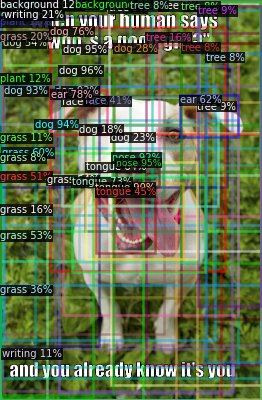

In [22]:
# Wrap data as appropriate
im_data = imgid2img[img]
pred = DictWrapper({"pred_boxes": im_data['boxes'], 
        "pred_classes": im_data['objects_id'], 
        "scores": im_data['objects_conf'], 
       })

# Show the boxes, labels, and features
im = cv2.imread(os.path.join(img_dir, f'{img}.png'))
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
v = Visualizer(im[:, :, :], MetadataCatalog.get("vg"), scale=0.5)
v = v.draw_instance_predictions(pred)
showarray(v.get_image()[:, :, ::-1])

In [14]:
print(pred.pred_classes)

[177 177  50 291  50  50 177  50 291 128 177 177 177  72 128 177  50  72
 177  51 308  50 177 128  50 128 308  50 308 308  72  50  50 299  50 462
 397 308  50 308 177 128 899 177 177 308 412 308 128  50 395 181 956 395
 412 299 308 128 177  72 923 956 128 128 128 412  72 308  51 299 308 177]


### Clean VG Attr 5

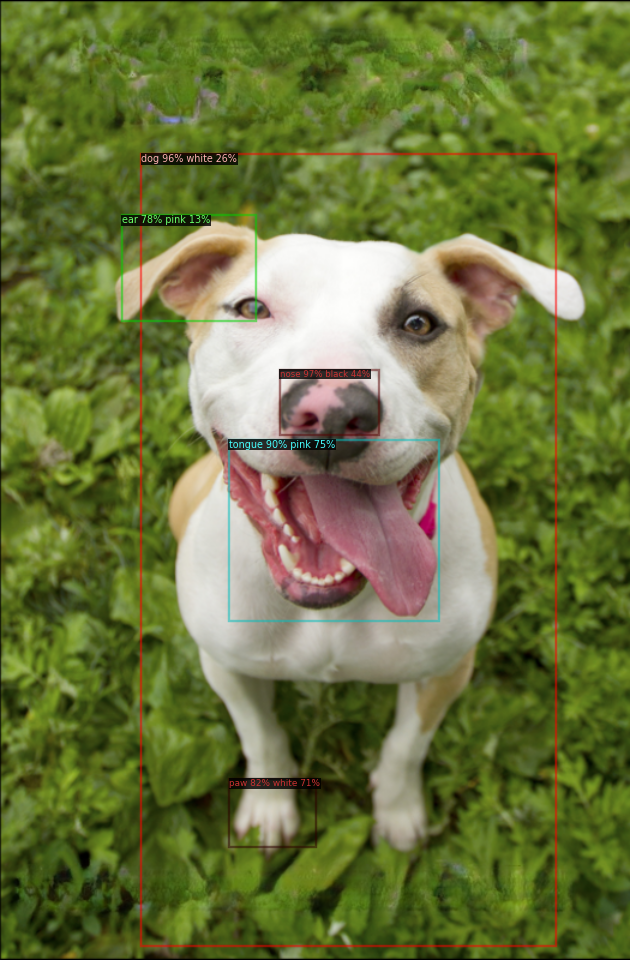

In [79]:
# Wrap data as appropriate
im_data = imgid2img[img]
pred = DictWrapper({"pred_boxes": im_data['boxes'], 
        "pred_classes": im_data['objects_id'], 
        "scores": im_data['objects_conf'], 
        "attr_classes": im_data['attrs_id'], 
        "attr_scores": im_data['attrs_conf'],
       })

# Show the boxes, labels, and features
im = cv2.imread(os.path.join(img_dir, f'{img}.png'))
im_rgb = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
v = Visualizer(im[:, :, :], MetadataCatalog.get("vg"), scale=1.2)
v = v.draw_instance_predictions(pred)
showarray(v.get_image()[:, :, ::-1])